<a href="https://colab.research.google.com/github/DeependraChaddha/Vlasov_Poisson_Solver/blob/main/vlasov_poisson_system_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Script for Vlasov Poisson System Solver

In [1]:
%%writefile vlasov_poisson_system.py
import os
import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from typing import Callable
import tqdm

class VlasovPoissonSolver:
    def __init__(self, nx: int, nv: int, nt: int, x_range: tuple, v_range: tuple, t_range: tuple, device: str):
        self.nx = nx
        self.nv = nv
        self.nt = nt
        self.x_range = x_range
        self.v_range = v_range
        self.t_range = t_range
        self.device = device if torch.cuda.is_available() else "cpu"
        self.model_checkpoint_path = None
        print("Instance of VlasovPoissonSolver created.")

    def make_grid(self):
        x = torch.linspace(self.x_range[0], self.x_range[1], self.nx).reshape(-1, 1)
        v = torch.linspace(self.v_range[0], self.v_range[1], self.nv).reshape(-1, 1)
        t = torch.linspace(self.t_range[0], self.t_range[1], self.nt).reshape(-1, 1)

        X, V, T = torch.meshgrid(x.squeeze(), v.squeeze(), t.squeeze(), indexing="ij")

        X = X.requires_grad_(True)
        V = V.requires_grad_(True)
        T = T.requires_grad_(True)

        self.X = X.to(self.device)
        self.V = V.to(self.device)
        self.T = T.to(self.device)
        return self.X, self.V, self.T

    def save_checkpoint(self, model, optimizer, loss, model_name, hyperparameters):
        self.checkpoint_dir = f"checkpoint_{model_name}_nx{self.nx}_nv{self.nv}_nt{self.nt}_epochs{hyperparameters['epochs']}"
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(self.checkpoint_dir, "model_checkpoint.pkl")
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            "hyperparameters": hyperparameters,
        }
        torch.save(checkpoint, checkpoint_path)
        self.model_checkpoint_path = checkpoint_path

    def train_step(self, model, loss_fn, optimizer, scheduler=None):
        # Forward Pass
        prediction = model(self.X, self.V, self.T, self.nx, self.nv, self.nt)

        # Compute Loss
        loss = loss_fn(model, self.X, self.V, self.T, self.nx, self.nv, self.nt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step(loss.item())

        return loss.item(), model.state_dict()

    def train(self, model, loss_fn, optimizer, epochs, model_name, get_loss_curve=False, scheduler=None):
        try:
          model = model.to(self.device)
          best_loss = float("inf")
          loss_values = []

          for epoch in tqdm.tqdm(range(epochs)):
              loss, model_params = self.train_step(model, loss_fn, optimizer, scheduler)
              loss_values.append(loss)

              if loss < best_loss:
                  best_loss = loss
                  self.save_checkpoint(model, optimizer, loss, model_name, {"epochs": epochs})

          print(f"Best Loss Achieved: {best_loss}")

          if get_loss_curve:
              plt.figure(figsize=(8, 5))
              plt.plot(range(1, epochs + 1), loss_values, marker="o", linestyle="-", color="r", label="Loss")
              plt.xlabel("Epoch")
              plt.ylabel("Loss")
              plt.title("Loss Curve Over Epochs")
              plt.legend()
              plt.grid()
              loss_curve_path = os.path.join(self.checkpoint_dir, "loss_curve.png")
              plt.savefig(loss_curve_path)
              print(f"Loss curve saved at {loss_curve_path}")
              plt.show()

              return self.model_checkpoint_path
        except AttributeError:
            print("Make grid first by calling make_grid()")

    def animate_final_prediction(self, model_class, model_checkpoint_path=None):
        try:
            if model_checkpoint_path is None:
                if self.model_checkpoint_path is None:
                    raise AttributeError("Model checkpoint not found. Train the model first.")
                model_checkpoint_path = self.model_checkpoint_path

            checkpoint = torch.load(model_checkpoint_path, map_location=self.device)
            model = model_class().to(self.device)
            model.load_state_dict(checkpoint["model_state_dict"])
            model.eval()

            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection="3d")

            with torch.no_grad():
                F_all = model(self.X, self.V, self.T, self.nx, self.nv, self.nt)  # Compute for all time steps

            def update(frame):
                ax.clear()
                ax.plot_surface(self.X.detach().cpu().numpy()[:,:,frame], self.V.detach().cpu().numpy()[:,:,frame], F_all.detach().cpu().numpy()[:,:,frame], cmap="viridis")
                ax.set_xlabel("X")
                ax.set_ylabel("V")
                ax.set_zlabel("F")
                ax.set_title(f"Predicted Distribution Function at Time {frame}")

            ani = FuncAnimation(fig, update, frames=self.nt, repeat=False)
            # Ensure checkpoint directory exists
            os.makedirs(self.checkpoint_dir, exist_ok=True)

            # Define file path and save animation
            animation_path = os.path.join(self.checkpoint_dir, "vlasov_distribution.gif")
            ani.save(animation_path, writer=PillowWriter(fps=10))

            # Store path in self.model_checkpoint_path
            self.model_checkpoint_path = animation_path
            print(f"Animation saved at: {animation_path}")

            # Close figure to free memory
            plt.close(fig)
            plt.show()
        except AttributeError as e:
            print(e)


Writing vlasov_poisson_system.py


#Using above script

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Instance of VlasovPoissonSolver created.


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Best Loss Achieved: 0.009532861411571503
Loss curve saved at checkpoint_DeepRitz_VlasovPoisson_nx30_nv30_nt30_epochs100/loss_curve.png


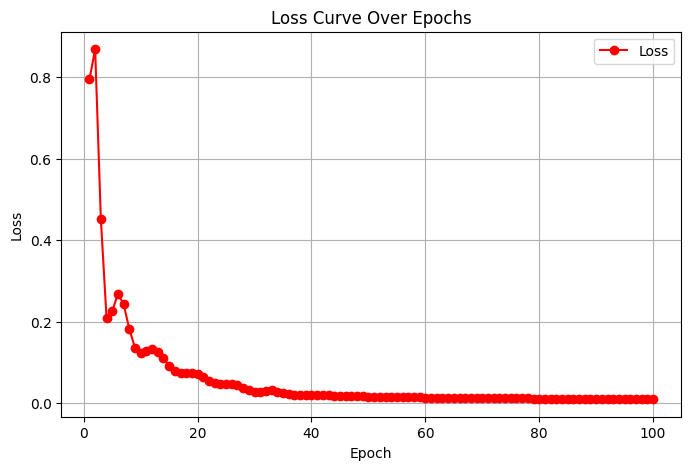

In [2]:
import vlasov_poisson_system  # Rename this module to match your modified version
from vlasov_poisson_system import VlasovPoissonSolver
import torch
import torch.nn as nn

class DeepRitzVlasovPoisson(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=8, use_fourier=True):
        super().__init__()
        self.use_fourier = use_fourier

        self.input_layer = nn.Linear(hidden_dim if use_fourier else input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

        if use_fourier:
            self.freq_embedding = nn.Linear(input_dim, hidden_dim)
            torch.nn.init.normal_(self.freq_embedding.weight, mean=0, std=1)

    def forward(self, X, V, T, nx, nv, nt):
        X, V, T = X.reshape(-1, 1), V.reshape(-1, 1), T.reshape(-1, 1)
        inputs = torch.cat((X, V, T), dim=1)

        if self.use_fourier:
            inputs = torch.sin(self.freq_embedding(inputs))

        x = self.activation(self.input_layer(inputs))  # Now input matches dimensions

        for layer in self.hidden_layers:
            residual = x
            x = self.activation(layer(x)) + residual

        return self.output_layer(x).view(nx, nv, nt)  # Ensure correct shape

model = DeepRitzVlasovPoisson()

'''Defining Loss function'''
def loss_fn(model: nn.Module, x: torch.Tensor, v: torch.Tensor, t: torch.Tensor,
            nx: int, nv: int, nt: int,
            boundary_loss_weight: float = 2.0,
            initial_loss_weight: float = 2.0):

    prediction = model(x, v, t, nx, nv, nt)

    # Compute first-order gradients
    f_x = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
    f_v = torch.autograd.grad(prediction, v, torch.ones_like(prediction), create_graph=True)[0]
    f_t = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0]

    # Compute the electric field by integrating f(x, v, t) over v
    rho = torch.trapz(prediction, v, dim=1)  # Charge density (integrating over v)
    E_x = torch.autograd.grad(rho, x, torch.ones_like(rho), create_graph=True)[0]  # ∂E/∂x = ρ - 1

    # Vlasov equation loss: ∂f/∂t + v∂f/∂x + E∂f/∂v = 0
    pde_loss = torch.mean((f_t + v * f_x + E_x * f_v) ** 2)

    # Boundary conditions (periodic in x, decay in v)
    boundary_loss = (
        (prediction[0, :, :] - prediction[-1, :, :])**2 +  # Periodic in x
        (prediction[:, 0, :] - torch.zeros_like(prediction[:, 0, :]))**2 +  # Decay in v
        (prediction[:, -1, :] - torch.zeros_like(prediction[:, -1, :]))**2
    ).mean()

    # Initial condition loss f(x,v,0)=e^(−v^2)*(1+0.3cos(4πx)sin(2πv)) #choosing this just to get a better looking graph
    initial_condition = torch.exp(-v[:, :, 0]**2) * (1 + 0.3 * torch.cos(4 * torch.pi * x[:, :, 0]) * torch.sin(2 * torch.pi * v[:, :, 0]))
    initial_condition_loss = torch.mean((prediction[:, :, 0] - initial_condition) ** 2)

    total_loss = pde_loss + (boundary_loss_weight * boundary_loss) + (initial_loss_weight * initial_condition_loss)
    return total_loss

'''Set Optimizer'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

'''Add Scheduler'''
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

'''Make solver instance'''
current_solver = VlasovPoissonSolver(nx=30, nv=30, nt=30, x_range=(0, 1), v_range=(-5, 5), t_range=(0, 1), device='cpu') ####Chose only 30 points in each dimension because of limited RAM availability

'''Make Grid'''
X, V, T = current_solver.make_grid()

'''Train'''
Z = current_solver.train(model=model,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=100,
                         model_name='DeepRitz_VlasovPoisson',
                         get_loss_curve=True,
                         scheduler=scheduler)


In [3]:
print(Z)

checkpoint_DeepRitz_VlasovPoisson_nx30_nv30_nt30_epochs100/model_checkpoint.pkl


In [4]:
current_solver.animate_final_prediction(model_class=DeepRitzVlasovPoisson)

/content/vlasov_poisson_system.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location=self.device)


Animation saved at: checkpoint_DeepRitz_VlasovPoisson_nx30_nv30_nt30_epochs100/vlasov_distribution.gif


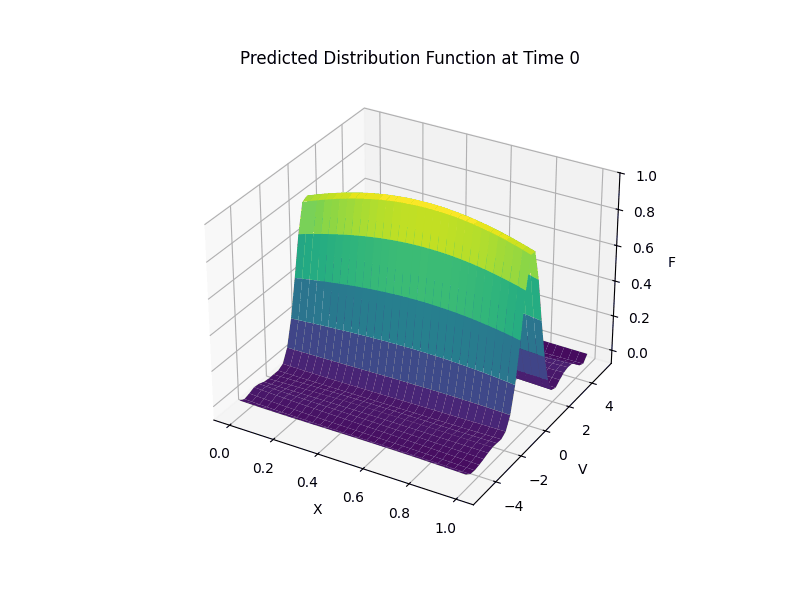

In [5]:
from IPython.display import display, Image
display(Image(filename='/content/checkpoint_DeepRitz_VlasovPoisson_nx30_nv30_nt30_epochs100/vlasov_distribution.gif'))